In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas correctamente")
print("Semilla aleatoria fijada en 42 para reproducibilidad")
print("Configuración de visualizaciones establecida")

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convertir a MB


def gower_distance(row1, row2, var_types, ranges=None):
    total_distance = 0.0
    total_weight = 0.0
    
    for i, var_type in enumerate(var_types):
        val1 = row1.iloc[i]
        val2 = row2.iloc[i]
        
        if pd.isna(val1) or pd.isna(val2):
            continue
        
        if var_type == 'numeric':
            if ranges and i < len(ranges):
                distance = abs(val1 - val2) / ranges[i]
            else:
                distance = abs(val1 - val2)
            weight = 1.0
            
        elif var_type == 'ordinal':
            distance = abs(val1 - val2)
            weight = 1.0
            
        elif var_type == 'categorical':
            distance = 0.0 if val1 == val2 else 1.0
            weight = 1.0
            
        elif var_type == 'binary':
            distance = 0.0 if val1 == val2 else 1.0
            weight = 1.0
        
        total_distance += distance * weight
        total_weight += weight
    
    if total_weight > 0:
        return total_distance / total_weight
    else:
        return 0.5 

def normalize_minmax(series):
    return (series - series.min()) / (series.max() - series.min())

education_mapping = {
    ' Preschool': 1, ' 1st-4th': 2, ' 5th-6th': 3, ' 7th-8th': 4, ' 9th': 5,
    ' 10th': 6, ' 11th': 7, ' 12th': 8, ' HS-grad': 9, ' Some-college': 10,
    ' Assoc-voc': 11, ' Assoc-acdm': 12, ' Bachelors': 13, ' Masters': 14,
    ' Prof-school': 15, ' Doctorate': 16
}
print(f"Memoria inicial: {get_memory_usage():.2f} MB")


Librerías importadas correctamente
Semilla aleatoria fijada en 42 para reproducibilidad
Configuración de visualizaciones establecida
Memoria inicial: 228.36 MB


In [4]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

print("Cargando dataset Adult Census...")
df = pd.read_csv('../../../datos/adult.data', names=column_names, na_values=' ?')

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Valores faltantes: {df.isnull().sum().sum()}")

print("\nAplicando limpieza de datos...")

categorical_missing = ['workclass', 'occupation', 'native_country']
for col in categorical_missing:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"  {col}: rellenado con '{mode_value}'")

df_clean = df.copy()


df_clean['income_binary'] = (df_clean['income'] == ' >50K').astype(int)

print(f"\nDataset limpio: {df_clean.shape[0]} filas, {df_clean.shape[1]} columnas")
print(f"Valores faltantes restantes: {df_clean.isnull().sum().sum()}")
print(f"Memoria después de carga: {get_memory_usage():.2f} MB")


Cargando dataset Adult Census...
Dataset cargado: 32561 filas, 15 columnas
Valores faltantes: 4262

Aplicando limpieza de datos...
  workclass: rellenado con ' Private'
  occupation: rellenado con ' Prof-specialty'
  native_country: rellenado con ' United-States'

Dataset limpio: 32561 filas, 16 columnas
Valores faltantes restantes: 0
Memoria después de carga: 236.32 MB


In [5]:

print("CREANDO VARIABLE DE AHORRO NETO")
print("="*50)

df_clean['net_capital'] = df_clean['capital_gain'] - df_clean['capital_loss']

print("Nueva variable creada: net_capital = capital_gain - capital_loss")
print(f"Valores positivos: ganancia neta")
print(f"Valores negativos: pérdida neta")
print(f"Valores cero: sin ganancias ni pérdidas")

print(f"\nESTADÍSTICAS DESCRIPTIVAS DE NET_CAPITAL:")
print("-" * 40)
print(f"Media: {df_clean['net_capital'].mean():.2f}")
print(f"Mediana: {df_clean['net_capital'].median():.2f}")
print(f"Desviación estándar: {df_clean['net_capital'].std():.2f}")
print(f"Mínimo: {df_clean['net_capital'].min():.2f}")
print(f"Máximo: {df_clean['net_capital'].max():.2f}")

print(f"\nDISTRIBUCIÓN DE VALORES:")
print("-" * 30)
print(f"Valores positivos (>0): {(df_clean['net_capital'] > 0).sum()} ({(df_clean['net_capital'] > 0).mean()*100:.1f}%)")
print(f"Valores negativos (<0): {(df_clean['net_capital'] < 0).sum()} ({(df_clean['net_capital'] < 0).mean()*100:.1f}%)")
print(f"Valores cero (=0): {(df_clean['net_capital'] == 0).sum()} ({(df_clean['net_capital'] == 0).mean()*100:.1f}%)")



CREANDO VARIABLE DE AHORRO NETO
Nueva variable creada: net_capital = capital_gain - capital_loss
Valores positivos: ganancia neta
Valores negativos: pérdida neta
Valores cero: sin ganancias ni pérdidas

ESTADÍSTICAS DESCRIPTIVAS DE NET_CAPITAL:
----------------------------------------
Media: 990.35
Mediana: 0.00
Desviación estándar: 7408.99
Mínimo: -4356.00
Máximo: 99999.00

DISTRIBUCIÓN DE VALORES:
------------------------------
Valores positivos (>0): 2712 (8.3%)
Valores negativos (<0): 1519 (4.7%)
Valores cero (=0): 28330 (87.0%)


In [6]:

print("NORMALIZACIÓN DE VARIABLES NUMÉRICAS")
print("="*50)


numeric_vars = ['age', 'net_capital', 'hours_per_week']

def normalize_minmax(series):
    """Normaliza una serie al rango [0,1] usando min-max"""
    return (series - series.min()) / (series.max() - series.min())


for var in numeric_vars:
    print(f"\nNormalizando {var}:")
    

    min_val = df_clean[var].min()
    max_val = df_clean[var].max()
    range_val = max_val - min_val
    
    df_clean[f'{var}_normalized'] = normalize_minmax(df_clean[var])
    
    print(f"  Rango original: [{min_val:.2f}, {max_val:.2f}]")
    print(f"  Rango de valores: {range_val:.2f}")
    

    norm_min = df_clean[f'{var}_normalized'].min()
    norm_max = df_clean[f'{var}_normalized'].max()
    print(f"  Rango normalizado: [{norm_min:.4f}, {norm_max:.4f}]")

print(f"\nVariables numéricas normalizadas: {[f'{var}_normalized' for var in numeric_vars]}")


NORMALIZACIÓN DE VARIABLES NUMÉRICAS

Normalizando age:
  Rango original: [17.00, 90.00]
  Rango de valores: 73.00
  Rango normalizado: [0.0000, 1.0000]

Normalizando net_capital:
  Rango original: [-4356.00, 99999.00]
  Rango de valores: 104355.00
  Rango normalizado: [0.0000, 1.0000]

Normalizando hours_per_week:
  Rango original: [1.00, 99.00]
  Rango de valores: 98.00
  Rango normalizado: [0.0000, 1.0000]

Variables numéricas normalizadas: ['age_normalized', 'net_capital_normalized', 'hours_per_week_normalized']


In [7]:

print("PROCESAMIENTO DE VARIABLE ORDINAL: EDUCATION")
print("="*50)

education_mapping = {
    ' Preschool': 1, ' 1st-4th': 2, ' 5th-6th': 3, ' 7th-8th': 4, ' 9th': 5,
    ' 10th': 6, ' 11th': 7, ' 12th': 8, ' HS-grad': 9, ' Some-college': 10,
    ' Assoc-voc': 11, ' Assoc-acdm': 12, ' Bachelors': 13, ' Masters': 14,
    ' Prof-school': 15, ' Doctorate': 16
}

print("Mapeo de education (ordinal):")
print("-" * 30)
for edu, code in education_mapping.items():
    normalized = (code - 1) / (16 - 1)  
    print(f"  {edu.strip():15s}: {code:2d} → {normalized:.3f}")


df_clean['education_encoded'] = df_clean['education'].map(education_mapping)


df_clean['education_normalized'] = (df_clean['education_encoded'] - 1) / (16 - 1)


print(f"\nVALIDACIÓN DE ENCODING Y NORMALIZACIÓN:")
print("-" * 40)
print(f"Valores únicos en education: {df_clean['education'].nunique()}")
print(f"Rango encoded: [{df_clean['education_encoded'].min()}, {df_clean['education_encoded'].max()}]")
print(f"Rango normalized: [{df_clean['education_normalized'].min():.4f}, {df_clean['education_normalized'].max():.4f}]")



PROCESAMIENTO DE VARIABLE ORDINAL: EDUCATION
Mapeo de education (ordinal):
------------------------------
  Preschool      :  1 → 0.000
  1st-4th        :  2 → 0.067
  5th-6th        :  3 → 0.133
  7th-8th        :  4 → 0.200
  9th            :  5 → 0.267
  10th           :  6 → 0.333
  11th           :  7 → 0.400
  12th           :  8 → 0.467
  HS-grad        :  9 → 0.533
  Some-college   : 10 → 0.600
  Assoc-voc      : 11 → 0.667
  Assoc-acdm     : 12 → 0.733
  Bachelors      : 13 → 0.800
  Masters        : 14 → 0.867
  Prof-school    : 15 → 0.933
  Doctorate      : 16 → 1.000

VALIDACIÓN DE ENCODING Y NORMALIZACIÓN:
----------------------------------------
Valores únicos en education: 16
Rango encoded: [1, 16]
Rango normalized: [0.0000, 1.0000]


In [8]:

print("VARIABLES CATEGÓRICAS NOMINALES Y BINARIAS")
print("="*50)


categorical_vars = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']

print("Las siguientes variables se mantienen como categóricas nominales:")
print("Gower las maneja automáticamente comparando por igualdad (0 si iguales, 1 si diferentes)")
print("-" * 70)

for var in categorical_vars:
    print(f"\n{var.upper()}:")
    unique_values = df_clean[var].unique()
    print(f"  Categorías ({len(unique_values)}): {list(unique_values)}")

print(f"\nVARIABLES BINARIAS")
print("="*50)

print("SEX:")
print(f"  Valores originales: {df_clean['sex'].unique()}")
df_clean['sex_binary'] = (df_clean['sex'] == ' Female').astype(int)
print(f"  Codificación: Male → 0, Female → 1")

print(f"\nINCOME:")
print(f"  Valores originales: {df_clean['income'].unique()}")
print(f"  Ya codificada como: <=50K → 0, >50K → 1")


VARIABLES CATEGÓRICAS NOMINALES Y BINARIAS
Las siguientes variables se mantienen como categóricas nominales:
Gower las maneja automáticamente comparando por igualdad (0 si iguales, 1 si diferentes)
----------------------------------------------------------------------

WORKCLASS:
  Categorías (8): [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Without-pay', ' Never-worked']

MARITAL_STATUS:
  Categorías (7): [' Never-married', ' Married-civ-spouse', ' Divorced', ' Married-spouse-absent', ' Separated', ' Married-AF-spouse', ' Widowed']

OCCUPATION:
  Categorías (14): [' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair', ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct', ' Tech-support', ' Protective-serv', ' Armed-Forces', ' Priv-house-serv']

RELATIONSHIP:
  Categorías (6): [' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried', ' Other-relativ

In [9]:

print("RESUMEN DE VARIABLES PREPARADAS PARA GOWER")
print("="*60)

gower_data = df_clean[[
    'age_normalized', 'workclass', 'education_normalized', 'marital_status',
    'occupation', 'relationship', 'race', 'sex_binary', 'net_capital_normalized',
    'hours_per_week_normalized', 'native_country', 'income_binary'
]].copy()

print(f"DataFrame preparado para Gower: {gower_data.shape[0]} filas, {gower_data.shape[1]} columnas")
print(f"Variables incluidas: {list(gower_data.columns)}")

print(f"\nVERIFICACIÓN DE TIPOS Y RANGOS:")
print("-" * 40)
for col in gower_data.columns:
    dtype = str(gower_data[col].dtype)
    if dtype in ['float64', 'int64']:
        min_val = gower_data[col].min()
        max_val = gower_data[col].max()
        print(f"{col:20s}: {dtype:10s} | [{min_val:.4f}, {max_val:.4f}]")
    else:
        n_unique = gower_data[col].nunique()
        print(f"{col:20s}: {dtype:10s} | {n_unique} categorías")

print(f"\nVERIFICACIÓN DE VALORES FALTANTES:")
print("-" * 40)
missing_count = gower_data.isnull().sum().sum()
if missing_count == 0:
    print("No hay valores faltantes en el dataset preparado")
else:
    print(f"Se encontraron {missing_count} valores faltantes")

print(f"\nDataset preparado para cálculo de distancia de Gower")
print(f"Memoria después de preprocesamiento: {get_memory_usage():.2f} MB")


RESUMEN DE VARIABLES PREPARADAS PARA GOWER
DataFrame preparado para Gower: 32561 filas, 12 columnas
Variables incluidas: ['age_normalized', 'workclass', 'education_normalized', 'marital_status', 'occupation', 'relationship', 'race', 'sex_binary', 'net_capital_normalized', 'hours_per_week_normalized', 'native_country', 'income_binary']

VERIFICACIÓN DE TIPOS Y RANGOS:
----------------------------------------
age_normalized      : float64    | [0.0000, 1.0000]
workclass           : object     | 8 categorías
education_normalized: float64    | [0.0000, 1.0000]
marital_status      : object     | 7 categorías
occupation          : object     | 14 categorías
relationship        : object     | 6 categorías
race                : object     | 5 categorías
sex_binary          : int64      | [0.0000, 1.0000]
net_capital_normalized: float64    | [0.0000, 1.0000]
hours_per_week_normalized: float64    | [0.0000, 1.0000]
native_country      : object     | 41 categorías
income_binary       : int64     

## Selección de Muestras Reproducibles

Ahora seleccionamos las dos muestras que utilizaremos para el análisis de escalabilidad:

- **Muestra 1**: 5,000 registros
- **Muestra 2**: 10,000 registros

Ambas muestras se seleccionan con `random_state=42` para garantizar reproducibilidad.


In [10]:
print("SELECCIÓN DE MUESTRAS REPRODUCIBLES")
print("="*50)

print("Seleccionando muestra de 5,000 registros...")
sample_5k = gower_data.sample(n=5000, random_state=42)
sample_5k_indices = sample_5k.index.tolist()

print(f"Muestra 5K: {sample_5k.shape[0]} filas, {sample_5k.shape[1]} columnas")
print(f"Índices de la muestra 5K: {sample_5k_indices[:10]}... (mostrando primeros 10)")

print(f"\nSeleccionando muestra de 10,000 registros...")
sample_10k = gower_data.sample(n=10000, random_state=42)
sample_10k_indices = sample_10k.index.tolist()

print(f"Muestra 10K: {sample_10k.shape[0]} filas, {sample_10k.shape[1]} columnas")
print(f"Índices de la muestra 10K: {sample_10k_indices[:10]}... (mostrando primeros 10)")

print(f"\nVERIFICACIÓN DE VALORES FALTANTES:")
print("-" * 40)
missing_5k = sample_5k.isnull().sum().sum()
missing_10k = sample_10k.isnull().sum().sum()

print(f"Muestra 5K: {missing_5k} valores faltantes")
print(f"Muestra 10K: {missing_10k} valores faltantes")

if missing_5k == 0 and missing_10k == 0:
    print("Ambas muestras están limpias (sin valores faltantes)")
else:
    print("Se encontraron valores faltantes en las muestras")

distances_5k = (5000 * (5000 - 1)) // 2
distances_10k = (10000 * (10000 - 1)) // 2

print(f"\nNÚMERO DE DISTANCIAS A CALCULAR:")
print("-" * 40)
print(f"Muestra 5K: {distances_5k:,} distancias")
print(f"Muestra 10K: {distances_10k:,} distancias")
print(f"Factor de crecimiento: {distances_10k / distances_5k:.2f}x")

print(f"\nMemoria después de selección de muestras: {get_memory_usage():.2f} MB")


SELECCIÓN DE MUESTRAS REPRODUCIBLES
Seleccionando muestra de 5,000 registros...
Muestra 5K: 5000 filas, 12 columnas
Índices de la muestra 5K: [14160, 27048, 28868, 5667, 7827, 15382, 4641, 8943, 216, 5121]... (mostrando primeros 10)

Seleccionando muestra de 10,000 registros...
Muestra 10K: 10000 filas, 12 columnas
Índices de la muestra 10K: [14160, 27048, 28868, 5667, 7827, 15382, 4641, 8943, 216, 5121]... (mostrando primeros 10)

VERIFICACIÓN DE VALORES FALTANTES:
----------------------------------------
Muestra 5K: 0 valores faltantes
Muestra 10K: 0 valores faltantes
Ambas muestras están limpias (sin valores faltantes)

NÚMERO DE DISTANCIAS A CALCULAR:
----------------------------------------
Muestra 5K: 12,497,500 distancias
Muestra 10K: 49,995,000 distancias
Factor de crecimiento: 4.00x

Memoria después de selección de muestras: 237.41 MB


## Cálculo de Matrices de Distancias de Gower

In [11]:

print("DEFINICIÓN DE TIPOS DE VARIABLES PARA GOWER")
print("="*50)


var_types = [
    'numeric',      # age_normalized
    'categorical',  # workclass
    'numeric',      # education_normalized (ya normalizada)
    'categorical',  # marital_status
    'categorical',  # occupation
    'categorical',  # relationship
    'categorical',  # race
    'binary',       # sex_binary
    'numeric',      # net_capital_normalized
    'numeric',      # hours_per_week_normalized
    'categorical',  # native_country
    'binary'        # income_binary
]

print(f"Tipos de variables definidos: {len(var_types)} variables")
print("Correspondencia con columnas:")
for i, (col, var_type) in enumerate(zip(gower_data.columns, var_types)):
    print(f"  {i+1:2d}. {col:20s} → {var_type}")


DEFINICIÓN DE TIPOS DE VARIABLES PARA GOWER
Tipos de variables definidos: 12 variables
Correspondencia con columnas:
   1. age_normalized       → numeric
   2. workclass            → categorical
   3. education_normalized → numeric
   4. marital_status       → categorical
   5. occupation           → categorical
   6. relationship         → categorical
   7. race                 → categorical
   8. sex_binary           → binary
   9. net_capital_normalized → numeric
  10. hours_per_week_normalized → numeric
  11. native_country       → categorical
  12. income_binary        → binary


In [12]:

print("CÁLCULO DE MATRIZ DE DISTANCIAS - MUESTRA 5,000")
print("="*60)


memory_before_5k = get_memory_usage()
print(f"Memoria antes del cálculo: {memory_before_5k:.2f} MB")


print("Iniciando cálculo de matriz de distancias con implementación manual...")
start_time_5k = time.time()


n = len(sample_5k)
distance_matrix_5k = np.zeros((n, n))

print(f"Calculando {n}×{n} = {n*n:,} distancias...")
for i in range(n):
    if i % 500 == 0:  
        print(f"  Procesando fila {i}/{n}")
    
    for j in range(i, n):
        if i == j:
            distance_matrix_5k[i, j] = 0.0
        else:
            dist = gower_distance(sample_5k.iloc[i], sample_5k.iloc[j], var_types)
            distance_matrix_5k[i, j] = dist
            distance_matrix_5k[j, i] = dist  

end_time_5k = time.time()
execution_time_5k = end_time_5k - start_time_5k


memory_after_5k = get_memory_usage()
memory_used_5k = memory_after_5k - memory_before_5k

print(f"\nRESULTADOS DEL CÁLCULO:")
print("-" * 40)
print(f"Tiempo de ejecución: {execution_time_5k:.4f} segundos")
print(f"Memoria antes: {memory_before_5k:.2f} MB")
print(f"Memoria después: {memory_after_5k:.2f} MB")
print(f"Memoria utilizada: {memory_used_5k:.2f} MB")
print(f"Dimensiones de la matriz: {distance_matrix_5k.shape}")


print(f"\nVALIDACIÓN DE PROPIEDADES:")
print("-" * 30)


is_symmetric_5k = np.allclose(distance_matrix_5k, distance_matrix_5k.T, rtol=1e-10)
print(f"1. Matriz simétrica: {'✅' if is_symmetric_5k else '❌'}")


diagonal_zeros_5k = np.allclose(np.diag(distance_matrix_5k), 0, rtol=1e-10)
print(f"2. Diagonal = 0: {'✅' if diagonal_zeros_5k else '❌'}")


min_val_5k = np.min(distance_matrix_5k)
max_val_5k = np.max(distance_matrix_5k)
in_range_5k = min_val_5k >= 0 and max_val_5k <= 1
print(f"3. Valores en [0,1]: {'✅' if in_range_5k else '❌'} (min: {min_val_5k:.4f}, max: {max_val_5k:.4f})")


np.save('distance_matrix_5000.npy', distance_matrix_5k)
file_size_5k = os.path.getsize('distance_matrix_5000.npy') / (1024 * 1024)  # MB
print(f"4. Matriz guardada: distance_matrix_5000.npy ({file_size_5k:.2f} MB)")

print(f"\nCálculo de matriz 5K completado exitosamente")


CÁLCULO DE MATRIZ DE DISTANCIAS - MUESTRA 5,000
Memoria antes del cálculo: 237.46 MB
Iniciando cálculo de matriz de distancias con implementación manual...
Calculando 5000×5000 = 25,000,000 distancias...
  Procesando fila 0/5000
  Procesando fila 500/5000
  Procesando fila 1000/5000
  Procesando fila 1500/5000
  Procesando fila 2000/5000
  Procesando fila 2500/5000
  Procesando fila 3000/5000
  Procesando fila 3500/5000
  Procesando fila 4000/5000
  Procesando fila 4500/5000

RESULTADOS DEL CÁLCULO:
----------------------------------------
Tiempo de ejecución: 1492.5392 segundos
Memoria antes: 237.46 MB
Memoria después: 428.20 MB
Memoria utilizada: 190.74 MB
Dimensiones de la matriz: (5000, 5000)

VALIDACIÓN DE PROPIEDADES:
------------------------------
1. Matriz simétrica: ✅
2. Diagonal = 0: ✅
3. Valores en [0,1]: ✅ (min: 0.0000, max: 0.8769)
4. Matriz guardada: distance_matrix_5000.npy (190.73 MB)

Cálculo de matriz 5K completado exitosamente


In [13]:

print("CÁLCULO DE MATRIZ DE DISTANCIAS - MUESTRA 10,000")
print("="*60)


memory_before_10k = get_memory_usage()
print(f"Memoria antes del cálculo: {memory_before_10k:.2f} MB")


print("Iniciando cálculo de matriz de distancias con implementación manual...")
start_time_10k = time.time()


n = len(sample_10k)
distance_matrix_10k = np.zeros((n, n))

print(f"Calculando {n}×{n} = {n*n:,} distancias...")
for i in range(n):
    if i % 1000 == 0:  
        print(f"  Procesando fila {i}/{n}")
    
    for j in range(i, n):
        if i == j:
            distance_matrix_10k[i, j] = 0.0
        else:
            dist = gower_distance(sample_10k.iloc[i], sample_10k.iloc[j], var_types)
            distance_matrix_10k[i, j] = dist
            distance_matrix_10k[j, i] = dist  

end_time_10k = time.time()
execution_time_10k = end_time_10k - start_time_10k


memory_after_10k = get_memory_usage()
memory_used_10k = memory_after_10k - memory_before_10k

print(f"\nRESULTADOS DEL CÁLCULO:")
print("-" * 40)
print(f"Tiempo de ejecución: {execution_time_10k:.4f} segundos")
print(f"Memoria antes: {memory_before_10k:.2f} MB")
print(f"Memoria después: {memory_after_10k:.2f} MB")
print(f"Memoria utilizada: {memory_used_10k:.2f} MB")
print(f"Dimensiones de la matriz: {distance_matrix_10k.shape}")


print(f"\nVALIDACIÓN DE PROPIEDADES:")
print("-" * 30)


is_symmetric_10k = np.allclose(distance_matrix_10k, distance_matrix_10k.T, rtol=1e-10)
print(f"1. Matriz simétrica: {'✅' if is_symmetric_10k else '❌'}")

diagonal_zeros_10k = np.allclose(np.diag(distance_matrix_10k), 0, rtol=1e-10)
print(f"2. Diagonal = 0: {'✅' if diagonal_zeros_10k else '❌'}")

min_val_10k = np.min(distance_matrix_10k)
max_val_10k = np.max(distance_matrix_10k)
in_range_10k = min_val_10k >= 0 and max_val_10k <= 1
print(f"3. Valores en [0,1]: {'✅' if in_range_10k else '❌'} (min: {min_val_10k:.4f}, max: {max_val_10k:.4f})")

np.save('distance_matrix_10000.npy', distance_matrix_10k)
file_size_10k = os.path.getsize('distance_matrix_10000.npy') / (1024 * 1024)  # MB
print(f"4. Matriz guardada: distance_matrix_10000.npy ({file_size_10k:.2f} MB)")

print(f"\nCálculo de matriz 10K completado exitosamente")


CÁLCULO DE MATRIZ DE DISTANCIAS - MUESTRA 10,000
Memoria antes del cálculo: 452.71 MB
Iniciando cálculo de matriz de distancias con implementación manual...
Calculando 10000×10000 = 100,000,000 distancias...
  Procesando fila 0/10000
  Procesando fila 1000/10000
  Procesando fila 2000/10000
  Procesando fila 3000/10000
  Procesando fila 4000/10000
  Procesando fila 5000/10000
  Procesando fila 6000/10000
  Procesando fila 7000/10000
  Procesando fila 8000/10000
  Procesando fila 9000/10000

RESULTADOS DEL CÁLCULO:
----------------------------------------
Tiempo de ejecución: 6890.6923 segundos
Memoria antes: 452.71 MB
Memoria después: 1215.90 MB
Memoria utilizada: 763.19 MB
Dimensiones de la matriz: (10000, 10000)

VALIDACIÓN DE PROPIEDADES:
------------------------------
1. Matriz simétrica: ✅
2. Diagonal = 0: ✅
3. Valores en [0,1]: ✅ (min: 0.0000, max: 0.8810)
4. Matriz guardada: distance_matrix_10000.npy (762.94 MB)

Cálculo de matriz 10K completado exitosamente


## Análisis Comparativo de Escalabilidad

Ahora analizamos cómo varían los tiempos y el consumo de memoria al aumentar el tamaño de la muestra, comparando con el crecimiento teórico O(n²).


In [14]:

print("ANÁLISIS COMPARATIVO DE ESCALABILIDAD")
print("="*60)

comparison_data = {
    'Métrica': [
        'Tamaño de muestra (n)',
        'Número de distancias calculadas',
        'Tiempo de ejecución (segundos)',
        'Memoria utilizada (MB)',
        'Tamaño de matriz en disco (MB)',
        'Memoria por distancia (MB)',
        'Tiempo por distancia (segundos)'
    ],
    'Muestra 5K': [
        '5,000',
        f'{distances_5k:,}',
        f'{execution_time_5k:.4f}',
        f'{memory_used_5k:.2f}',
        f'{file_size_5k:.2f}',
        f'{memory_used_5k/distances_5k*1e6:.6f}',
        f'{execution_time_5k/distances_5k*1e6:.6f}'
    ],
    'Muestra 10K': [
        '10,000',
        f'{distances_10k:,}',
        f'{execution_time_10k:.4f}',
        f'{memory_used_10k:.2f}',
        f'{file_size_10k:.2f}',
        f'{memory_used_10k/distances_10k*1e6:.6f}',
        f'{execution_time_10k/distances_10k*1e6:.6f}'
    ]
}


comparison_df = pd.DataFrame(comparison_data)
print("TABLA COMPARATIVA DE MÉTRICAS:")
print("-" * 80)
print(comparison_df.to_string(index=False))

print(f"\nFACTORES DE CRECIMIENTO:")
print("-" * 40)

theoretical_factor = 4.0

time_factor = execution_time_10k / execution_time_5k
memory_factor = memory_used_10k / memory_used_5k
file_size_factor = file_size_10k / file_size_5k
distances_factor = distances_10k / distances_5k

print(f"Factor de crecimiento de tiempo: {time_factor:.2f}x")
print(f"Factor de crecimiento de memoria: {memory_factor:.2f}x")
print(f"Factor de crecimiento de archivo: {file_size_factor:.2f}x")
print(f"Factor de crecimiento de distancias: {distances_factor:.2f}x")
print(f"Factor teórico esperado (O(n²)): {theoretical_factor:.2f}x")

time_efficiency = theoretical_factor / time_factor
memory_efficiency = theoretical_factor / memory_factor

print(f"\nEFICIENCIA RELATIVA:")
print("-" * 30)
print(f"Eficiencia de tiempo: {time_efficiency:.2f} (1.0 = óptimo)")
print(f"Eficiencia de memoria: {memory_efficiency:.2f} (1.0 = óptimo)")


ANÁLISIS COMPARATIVO DE ESCALABILIDAD
TABLA COMPARATIVA DE MÉTRICAS:
--------------------------------------------------------------------------------
                        Métrica Muestra 5K Muestra 10K
          Tamaño de muestra (n)      5,000      10,000
Número de distancias calculadas 12,497,500  49,995,000
 Tiempo de ejecución (segundos)  1492.5392   6890.6923
         Memoria utilizada (MB)     190.74      763.19
 Tamaño de matriz en disco (MB)     190.73      762.94
     Memoria por distancia (MB)  15.262115   15.265277
Tiempo por distancia (segundos) 119.427020  137.827629

FACTORES DE CRECIMIENTO:
----------------------------------------
Factor de crecimiento de tiempo: 4.62x
Factor de crecimiento de memoria: 4.00x
Factor de crecimiento de archivo: 4.00x
Factor de crecimiento de distancias: 4.00x
Factor teórico esperado (O(n²)): 4.00x

EFICIENCIA RELATIVA:
------------------------------
Eficiencia de tiempo: 0.87 (1.0 = óptimo)
Eficiencia de memoria: 1.00 (1.0 = óptimo)


VISUALIZACIONES DE ESCALABILIDAD


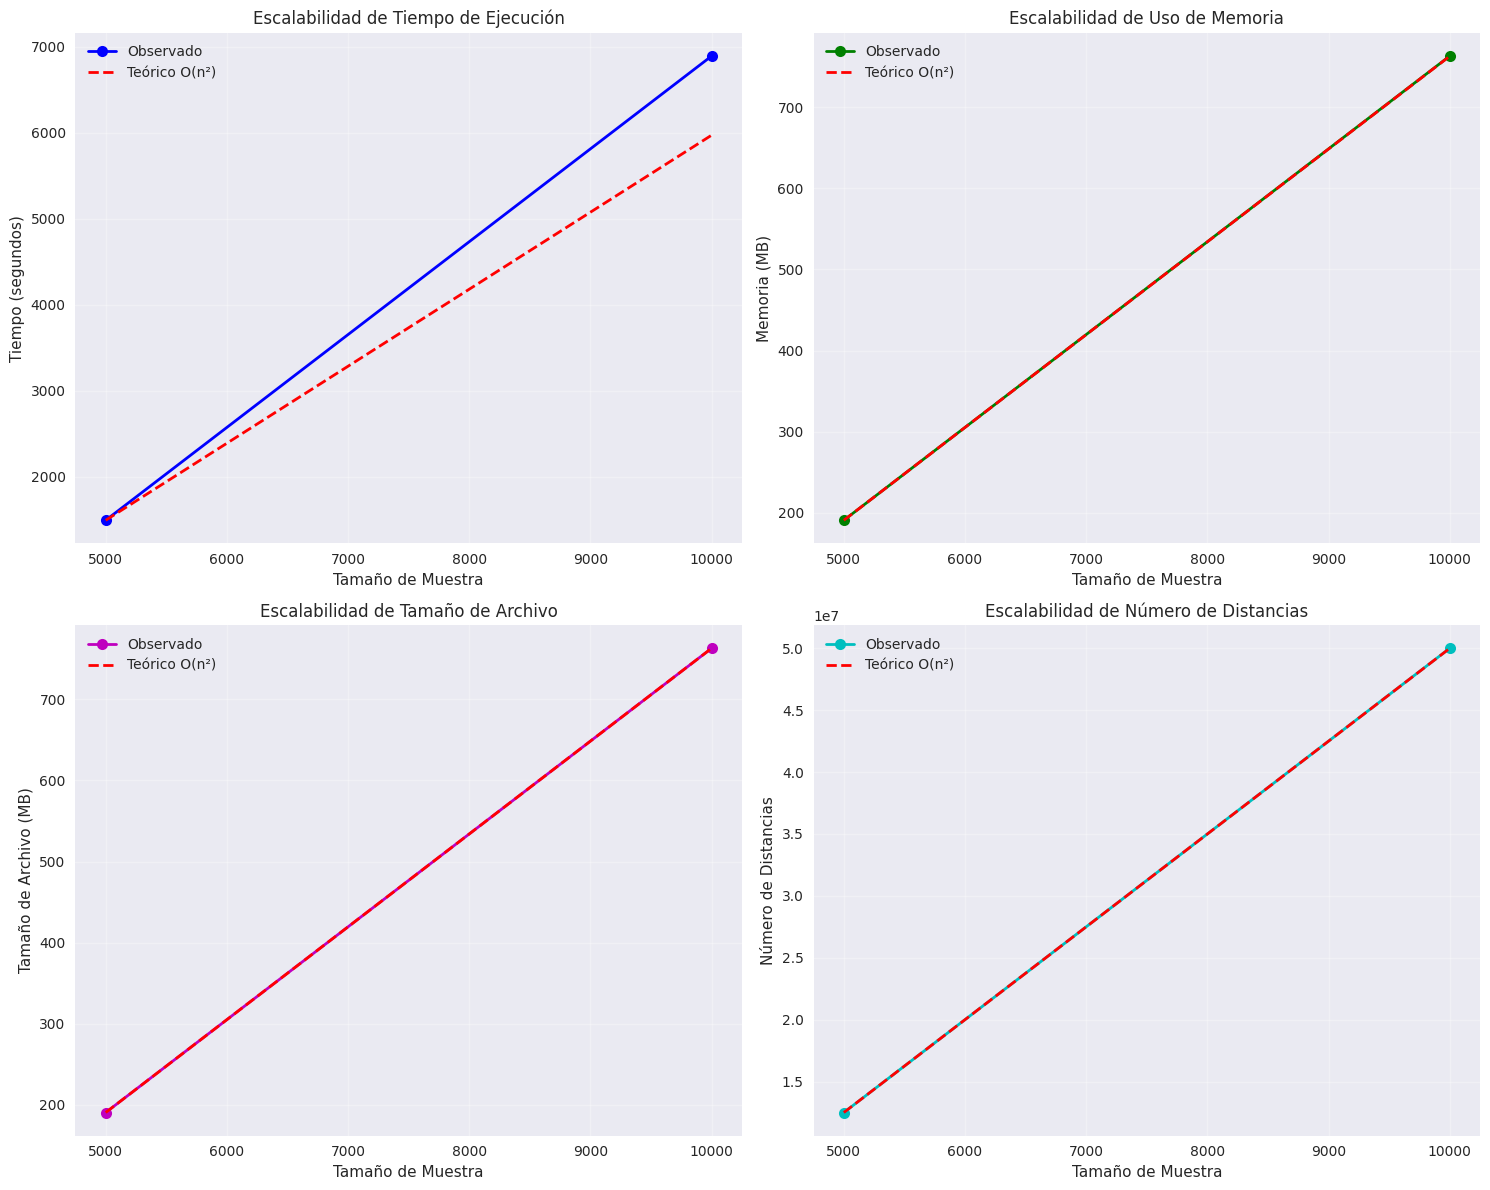

In [15]:

print("VISUALIZACIONES DE ESCALABILIDAD")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sample_sizes = [5000, 10000]
times = [execution_time_5k, execution_time_10k]
memories = [memory_used_5k, memory_used_10k]
file_sizes = [file_size_5k, file_size_10k]
distances = [distances_5k, distances_10k]

axes[0, 0].plot(sample_sizes, times, 'bo-', linewidth=2, markersize=8, label='Observado')
axes[0, 0].plot(sample_sizes, [times[0], times[0] * 4], 'r--', linewidth=2, label='Teórico O(n²)')
axes[0, 0].set_xlabel('Tamaño de Muestra')
axes[0, 0].set_ylabel('Tiempo (segundos)')
axes[0, 0].set_title('Escalabilidad de Tiempo de Ejecución')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(sample_sizes, memories, 'go-', linewidth=2, markersize=8, label='Observado')
axes[0, 1].plot(sample_sizes, [memories[0], memories[0] * 4], 'r--', linewidth=2, label='Teórico O(n²)')
axes[0, 1].set_xlabel('Tamaño de Muestra')
axes[0, 1].set_ylabel('Memoria (MB)')
axes[0, 1].set_title('Escalabilidad de Uso de Memoria')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(sample_sizes, file_sizes, 'mo-', linewidth=2, markersize=8, label='Observado')
axes[1, 0].plot(sample_sizes, [file_sizes[0], file_sizes[0] * 4], 'r--', linewidth=2, label='Teórico O(n²)')
axes[1, 0].set_xlabel('Tamaño de Muestra')
axes[1, 0].set_ylabel('Tamaño de Archivo (MB)')
axes[1, 0].set_title('Escalabilidad de Tamaño de Archivo')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(sample_sizes, distances, 'co-', linewidth=2, markersize=8, label='Observado')
axes[1, 1].plot(sample_sizes, [distances[0], distances[0] * 4], 'r--', linewidth=2, label='Teórico O(n²)')
axes[1, 1].set_xlabel('Tamaño de Muestra')
axes[1, 1].set_ylabel('Número de Distancias')
axes[1, 1].set_title('Escalabilidad de Número de Distancias')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()


## Análisis Estadístico de las Matrices

Analizamos las distribuciones de distancias en ambas matrices para evaluar si las muestras son representativas del dataset completo.


In [16]:

print("ANÁLISIS ESTADÍSTICO DE LAS MATRICES")
print("="*60)


upper_tri_indices_5k = np.triu_indices_from(distance_matrix_5k, k=1)
distances_5k_values = distance_matrix_5k[upper_tri_indices_5k]

upper_tri_indices_10k = np.triu_indices_from(distance_matrix_10k, k=1)
distances_10k_values = distance_matrix_10k[upper_tri_indices_10k]


print("ESTADÍSTICAS DESCRIPTIVAS - MUESTRA 5K:")
print("-" * 50)
print(f"Media: {np.mean(distances_5k_values):.4f}")
print(f"Mediana: {np.median(distances_5k_values):.4f}")
print(f"Desviación estándar: {np.std(distances_5k_values):.4f}")
print(f"Mínimo: {np.min(distances_5k_values):.4f}")
print(f"Máximo: {np.max(distances_5k_values):.4f}")
print(f"Q1 (25%): {np.percentile(distances_5k_values, 25):.4f}")
print(f"Q3 (75%): {np.percentile(distances_5k_values, 75):.4f}")

print(f"\nESTADÍSTICAS DESCRIPTIVAS - MUESTRA 10K:")
print("-" * 50)
print(f"Media: {np.mean(distances_10k_values):.4f}")
print(f"Mediana: {np.median(distances_10k_values):.4f}")
print(f"Desviación estándar: {np.std(distances_10k_values):.4f}")
print(f"Mínimo: {np.min(distances_10k_values):.4f}")
print(f"Máximo: {np.max(distances_10k_values):.4f}")
print(f"Q1 (25%): {np.percentile(distances_10k_values, 25):.4f}")
print(f"Q3 (75%): {np.percentile(distances_10k_values, 75):.4f}")


print(f"\nCOMPARACIÓN DE DISTRIBUCIONES:")
print("-" * 40)
mean_diff = abs(np.mean(distances_10k_values) - np.mean(distances_5k_values))
median_diff = abs(np.median(distances_10k_values) - np.median(distances_5k_values))
std_diff = abs(np.std(distances_10k_values) - np.std(distances_5k_values))

print(f"Diferencia en media: {mean_diff:.4f}")
print(f"Diferencia en mediana: {median_diff:.4f}")
print(f"Diferencia en desviación estándar: {std_diff:.4f}")

# Evaluar representatividad
if mean_diff < 0.01 and median_diff < 0.01:
    print("Las muestras son estadísticamente similares (representativas)")
else:
    print("Las muestras muestran diferencias estadísticas significativas")



ANÁLISIS ESTADÍSTICO DE LAS MATRICES
ESTADÍSTICAS DESCRIPTIVAS - MUESTRA 5K:
--------------------------------------------------
Media: 0.3701
Mediana: 0.3736
Desviación estándar: 0.1269
Mínimo: 0.0000
Máximo: 0.8769
Q1 (25%): 0.2828
Q3 (75%): 0.4595

ESTADÍSTICAS DESCRIPTIVAS - MUESTRA 10K:
--------------------------------------------------
Media: 0.3713
Mediana: 0.3742
Desviación estándar: 0.1272
Mínimo: 0.0000
Máximo: 0.8810
Q1 (25%): 0.2833
Q3 (75%): 0.4605

COMPARACIÓN DE DISTRIBUCIONES:
----------------------------------------
Diferencia en media: 0.0012
Diferencia en mediana: 0.0006
Diferencia en desviación estándar: 0.0003
Las muestras son estadísticamente similares (representativas)


VISUALIZACIÓN DE DISTRIBUCIONES DE DISTANCIAS


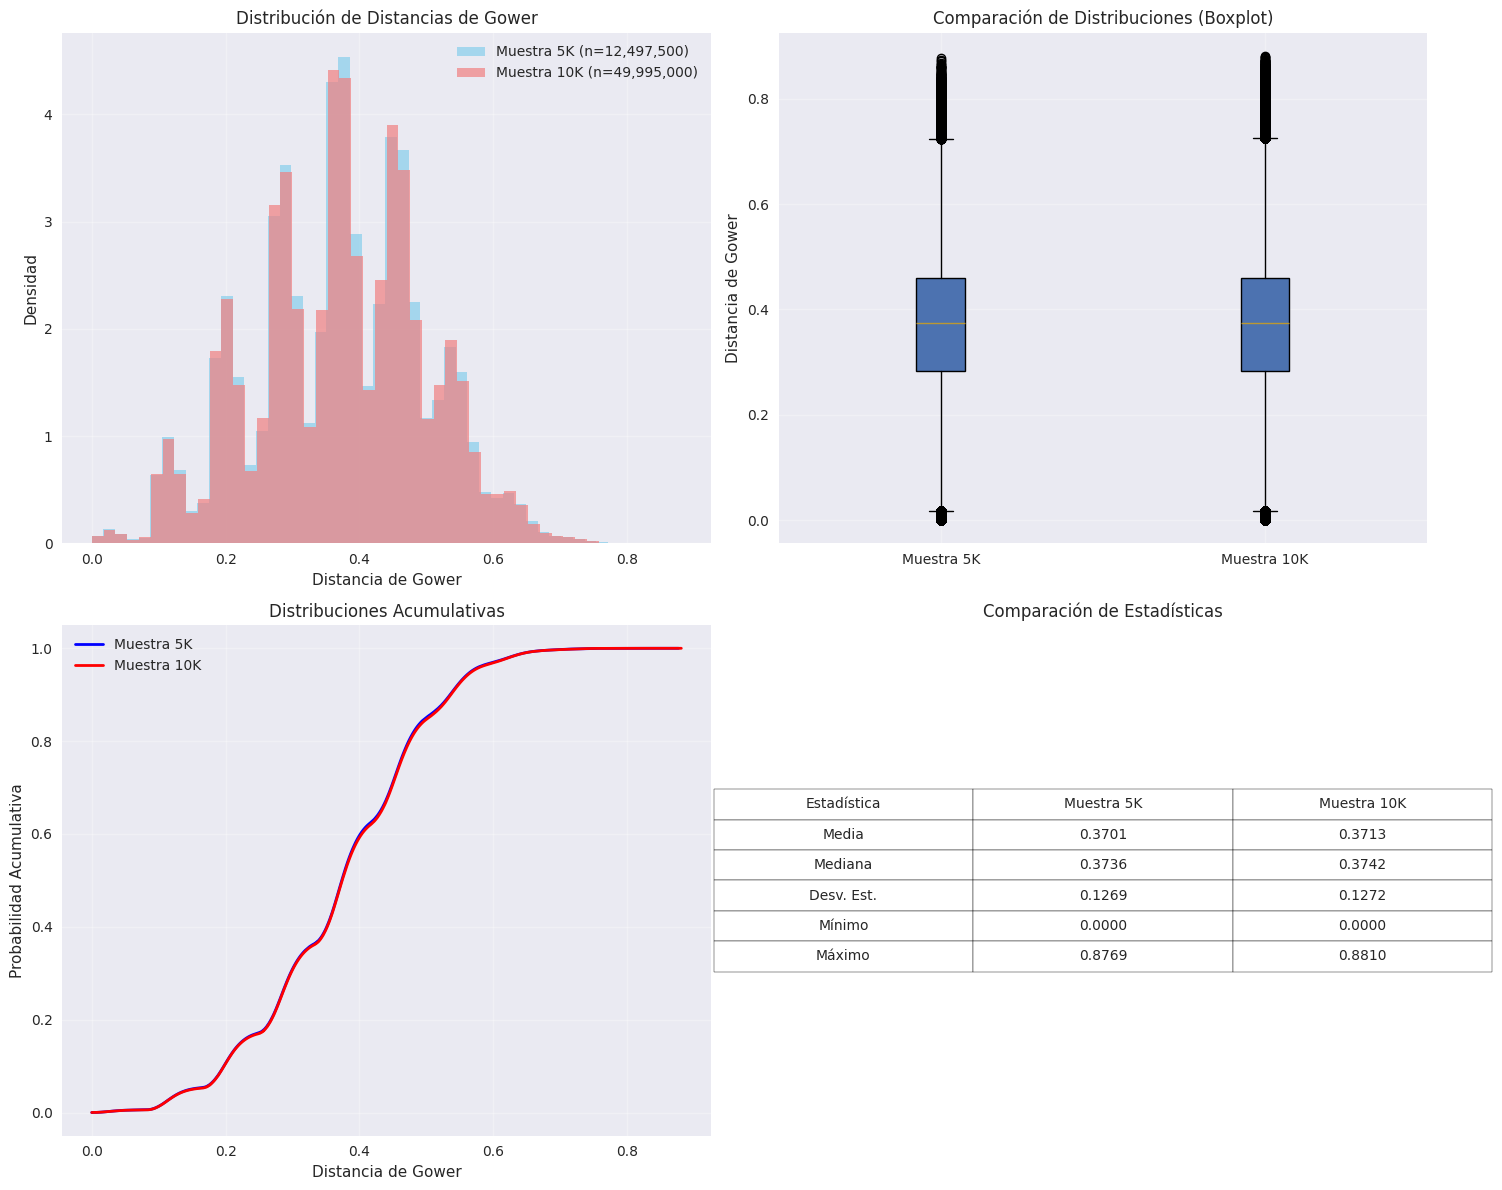

In [17]:

print("VISUALIZACIÓN DE DISTRIBUCIONES DE DISTANCIAS")
print("="*60)


fig, axes = plt.subplots(2, 2, figsize=(15, 12))


axes[0, 0].hist(distances_5k_values, bins=50, alpha=0.7, color='skyblue', 
                label=f'Muestra 5K (n={len(distances_5k_values):,})', density=True)
axes[0, 0].hist(distances_10k_values, bins=50, alpha=0.7, color='lightcoral', 
                label=f'Muestra 10K (n={len(distances_10k_values):,})', density=True)
axes[0, 0].set_xlabel('Distancia de Gower')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].set_title('Distribución de Distancias de Gower')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


box_data = [distances_5k_values, distances_10k_values]
box_labels = ['Muestra 5K', 'Muestra 10K']
axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
axes[0, 1].set_ylabel('Distancia de Gower')
axes[0, 1].set_title('Comparación de Distribuciones (Boxplot)')
axes[0, 1].grid(True, alpha=0.3)


sorted_distances_5k = np.sort(distances_5k_values)
cumulative_prob_5k = np.arange(1, len(sorted_distances_5k) + 1) / len(sorted_distances_5k)

sorted_distances_10k = np.sort(distances_10k_values)
cumulative_prob_10k = np.arange(1, len(sorted_distances_10k) + 1) / len(sorted_distances_10k)

axes[1, 0].plot(sorted_distances_5k, cumulative_prob_5k, linewidth=2, 
                color='blue', label='Muestra 5K')
axes[1, 0].plot(sorted_distances_10k, cumulative_prob_10k, linewidth=2, 
                color='red', label='Muestra 10K')
axes[1, 0].set_xlabel('Distancia de Gower')
axes[1, 0].set_ylabel('Probabilidad Acumulativa')
axes[1, 0].set_title('Distribuciones Acumulativas')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


stats_comparison = {
    'Estadística': ['Media', 'Mediana', 'Desv. Est.', 'Mínimo', 'Máximo'],
    'Muestra 5K': [
        f'{np.mean(distances_5k_values):.4f}',
        f'{np.median(distances_5k_values):.4f}',
        f'{np.std(distances_5k_values):.4f}',
        f'{np.min(distances_5k_values):.4f}',
        f'{np.max(distances_5k_values):.4f}'
    ],
    'Muestra 10K': [
        f'{np.mean(distances_10k_values):.4f}',
        f'{np.median(distances_10k_values):.4f}',
        f'{np.std(distances_10k_values):.4f}',
        f'{np.min(distances_10k_values):.4f}',
        f'{np.max(distances_10k_values):.4f}'
    ]
}

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for i, stat in enumerate(stats_comparison['Estadística']):
    table_data.append([stat, stats_comparison['Muestra 5K'][i], stats_comparison['Muestra 10K'][i]])

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Estadística', 'Muestra 5K', 'Muestra 10K'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Comparación de Estadísticas')

plt.tight_layout()
plt.show()
